In [62]:
import numpy as np
from tqdm import tqdm
import pymc as pm
import skfem as fem
from skfem import MeshLine, ElementLineP1, Basis, BilinearForm, LinearForm
from skfem.helpers import dot, grad, d, dd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import truncnorm
import scipy.stats as scstats
import scipy.sparse as scsparse
import scipy.optimize as scoptimize
import scipy.linalg as sclinalg

import pytensor.tensor.subtensor as subtensor
import pytensor.tensor as tensor
import arviz as az

In [63]:
import scienceplots
# plot params
contour_levels = 20
plt.style.use(['science', 'grid'])
color_list = [(253, 231, 37),(194, 223, 35),(134, 213, 73),(82, 197, 105),(42, 176, 127),(30, 155, 138),(37, 133, 142),(45, 112, 142),(56, 88, 140),(67, 62, 133),(72, 33, 115),(68, 1, 84)]
color_list = [tuple(ti/255 for ti in t) for t in color_list]

In [118]:
#number_of_x_axial_cells = 200
number_of_x_axial_cells = 200

# x_axis_left_boundary = 0.
# x_axis_right_boundary = 1.

x_axis_left_boundary = -6.
x_axis_right_boundary = 6.

x_s = np.linspace(x_axis_left_boundary, x_axis_right_boundary, number_of_x_axial_cells)

t_start = 0
dt = 0.02
t_end = 4.
time_range = np.arange(t_start, t_end, dt)
number_of_steps = len(time_range)

true_nu = 0.01

mesh = fem.MeshLine(x_s)
element = fem.ElementLineP1()
basis = fem.Basis(mesh, element)

newton_tol = 0.00001

true_coordinates = mesh.p.T
n_x = len(true_coordinates)
boundary_condition = (
    (true_coordinates == x_axis_left_boundary) | (true_coordinates == x_axis_right_boundary)
)
boundary_indices = np.where(boundary_condition)[0]

#u_0 = np.sin(2*np.pi*true_coordinates).flatten()
#u_0 = np.exp((-(true_coordinates.flatten())**2)/2)
u_0true = np.exp(-((true_coordinates.flatten()-1)**2)/2) - np.exp(-((true_coordinates.flatten()+1)**2)/2) 
u_strue = np.zeros((number_of_steps, n_x))
u_strue[0,:] = u_0true

u_guess = u_0true + np.random.normal(0, 0.001, len(u_0true))
u_guess[0] = u_guess[-1] = 0

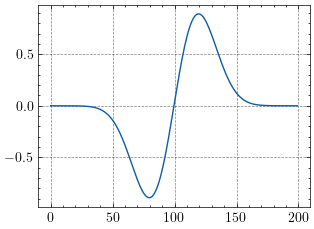

In [119]:
plt.plot(u_0true)

In [120]:
# Observation Parameters
sigma_n_true = 0.05
spatial_points = 8
temporal_points = 10

temp = np.linspace(0, len(true_coordinates) - 1, spatial_points+2, dtype=int)
spatial_measurement_indices = temp[1:-1]
spatial_measurement_coordinates = true_coordinates[spatial_measurement_indices]
temp = np.linspace(0, len(time_range) - 1, temporal_points+2, dtype=int)
temporal_measurement_indices = temp[1:-1]
temporal_measurement_coordinates = time_range[temporal_measurement_indices]

In [121]:
import sympy as sp

# Define the symbols and functions
x = sp.symbols('x')  # Spatial variable
u, u_0, v, u_hat = sp.symbols(r'u u_0 v \hat{u}', cls=sp.Function)  # Functions
Delta_t, nu, epsilon = sp.symbols('Delta_t nu epsilon')  # Constants

# Define the derivatives
u_prime = sp.diff(u(x), x)
u_0prime = sp.diff(u_0(x),x)
v_prime = sp.diff(v(x), x)

# Define the functional F
#F = (u(x) + Delta_t * u(x) * u_prime - u_0(x)) * v(x) + Delta_t * nu * u_prime * v_prime
F = (u(x)*(1+(Delta_t/2)*u_prime))*v(x) + (Delta_t * nu / 2)*(u_prime*v_prime) - (u_0(x)*(1-(Delta_t/2)*u_0prime))*v(x) + (Delta_t*nu/2)*(u_0prime*v_prime)

# Define the perturbed functional F(u + epsilon * u_hat)
u_perturbed = u(x) + epsilon * u_hat(x)
u_perturbed_prime = sp.diff(u_perturbed, x)
#F_perturbed = (u_perturbed + Delta_t * u_perturbed * u_perturbed_prime - u_0(x)) * v(x) + Delta_t * nu * u_perturbed_prime * v_prime
F_perturbed = (u_perturbed*(1+(Delta_t/2)*u_perturbed_prime))*v(x) + (Delta_t * nu / 2)*(u_perturbed_prime*v_prime) - (u_0(x)*(1-(Delta_t/2)*u_0prime))*v(x) + (Delta_t*nu/2)*(u_0prime*v_prime)

# Compute the Gâteaux derivative (directional derivative)
Gateaux_derivative = sp.limit((F_perturbed - F) / epsilon, epsilon, 0)

# Display the result
Gateaux_derivative_simplified = sp.simplify(Gateaux_derivative)
Gateaux_derivative_simplified


Delta_t*nu*Derivative(\hat{u}(x), x)*Derivative(v(x), x)/2 + Delta_t*\hat{u}(x)*v(x)*Derivative(u(x), x)/2 + Delta_t*u(x)*v(x)*Derivative(\hat{u}(x), x)/2 + \hat{u}(x)*v(x)

In [122]:
# EXPLICIT EULER

@fem.LinearForm
def F_functional(v,w):
    return (w.u_k + dt*w.u_k*grad(w.u_k)[0]-w.u_0)*v + dt*true_nu*dot(grad(w.u_k),grad(v))

@fem.BilinearForm
def F_jacobian(u,v,w):
    return u*v + dt*w.u_k*grad(u)[0]*v + dt*grad(w.u_k)[0]*u*v + dt*true_nu*dot(grad(u),grad(v))

# CRANK NICHOLSON

@fem.LinearForm
def F_functional(v,w):
    return w.u_k*(1+(dt/2)*grad(w.u_k)[0])*v + (dt*true_nu/2)*dot(grad(w.u_k), grad(v)) - w.u_0*(1-(dt/2)*grad(w.u_0)[0])*v + (dt*true_nu/2)*dot(grad(w.u_0), grad(v))

@fem.BilinearForm
def F_jacobian(u,v,w):
    return u*v + (dt*true_nu/2)*dot(grad(u),grad(v)) + (dt/2)*u*grad(w.u_k)[0]*v + (dt/2)*grad(u)[0]*w.u_k*v

In [123]:
for i in tqdm(range(number_of_steps-1)):
    du_norm = 1.
    while du_norm > newton_tol:
        # calculate the residual, with the next u_k being our guess, and u_0 being the previous point
        u_k_resid = F_functional.assemble(basis, u_k = basis.interpolate(u_guess), u_0 = basis.interpolate(u_strue[i,:]))
        # set boundary conditions
        u_k_resid[0] = u_k_resid[-1] = 0.
        j_mat = F_jacobian.assemble(basis, u_k = basis.interpolate(u_guess), u_0 = basis.interpolate(u_strue[i,:]))
        j_mat[0,:] = j_mat[-1,:] = 0.
        j_mat[0,0] = j_mat[-1,-1] = 1.
        du_norm = np.linalg.norm(u_k_resid)
        u_guess = u_guess + scsparse.linalg.spsolve(j_mat, -u_k_resid)
    u_strue[i+1,:] = u_guess


100%|██████████| 199/199 [00:02<00:00, 78.95it/s] 


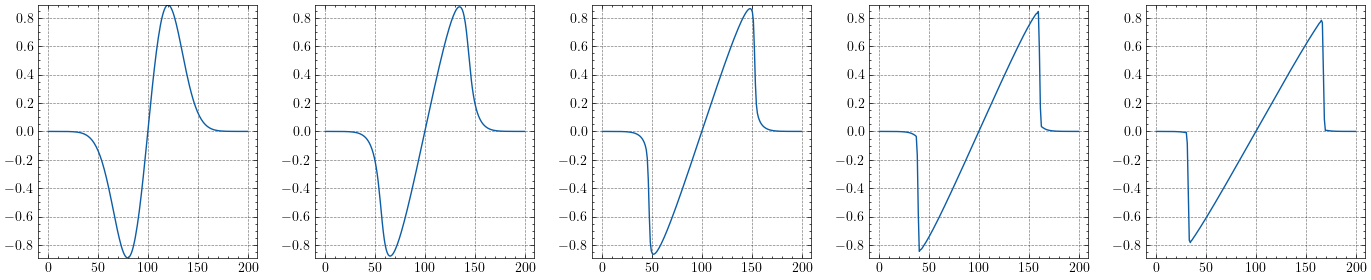

In [124]:
u_observed = u_strue[temporal_measurement_indices][:, spatial_measurement_indices] + np.random.normal(0, sigma_n_true, (temporal_points, spatial_points))

fig, axes = plt.subplots(1, 5, figsize=(14,3))
ymin = np.min(u_strue[1])
ymax = np.max(u_strue[1])
axes[0].plot(u_strue[1])
axes[0].set_ylim(ymin, ymax)
axes[1].plot(u_strue[51])
axes[1].set_ylim(ymin, ymax)
axes[2].plot(u_strue[101])
axes[2].set_ylim(ymin, ymax)
axes[3].plot(u_strue[151])
axes[3].set_ylim(ymin, ymax)
axes[4].plot(u_strue[199])
axes[4].set_ylim(ymin, ymax)
fig.tight_layout()
plt.show()

In [10]:
for i in tqdm(range(number_of_steps-1)):
    def residual(u_guess):
        vec = F_functional.assemble(basis, u_k = basis.interpolate(u_guess), u_0 = basis.interpolate(u_strue[i,:]))
        vec[0] = vec[-1] = 0
        return vec
    u_next = scoptimize.root(residual, u_strue[i,:], method='krylov').x
    u_strue[i+1,:] = u_next

100%|██████████| 199/199 [00:03<00:00, 57.33it/s]


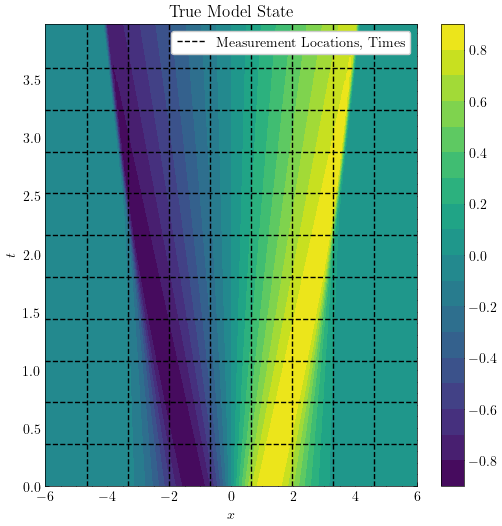

In [125]:
fig, axes = plt.subplots(figsize=(6,6))
plot = axes.contourf(true_coordinates.flatten(), time_range, u_strue, levels=contour_levels)
num = 0
for coord in spatial_measurement_coordinates.flatten():
    if num == 0:
        axes.axvline(coord, linestyle='--', label='Measurement Locations, Times', color='black')
    else:
        axes.axvline(coord, linestyle='--', color='black')
    num += 1
num = 0
for coord in temporal_measurement_coordinates.flatten():
    if num == 0:
        axes.axhline(coord, linestyle='--', color='black')
    else:
        axes.axhline(coord, linestyle='--', color='black')
    num += 1

x_temp, y_temp = np.meshgrid(true_coordinates[spatial_measurement_indices].flatten(), time_range[temporal_measurement_indices].flatten())
x_temp, y_temp = x_temp.flatten(), y_temp.flatten()

#axes.scatter(x_temp, y_temp, marker='x', label='Observed Points', color='black')
axes.set_xlabel(r'$x$')
axes.set_ylabel(r'$t$')
axes.set_title('True Model State')
fig.colorbar(plot)
plt.legend()
plt.show()

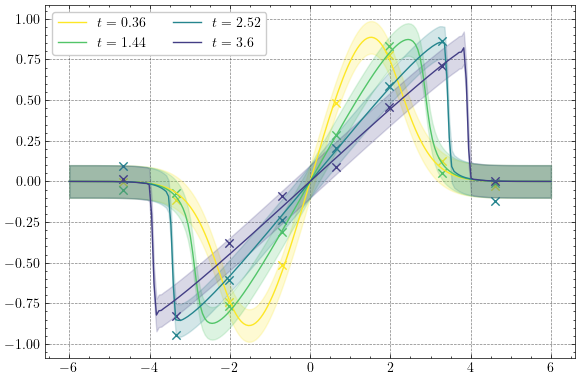

In [129]:
time_labels = [r"$t=$ "+str(round(temporal_measurement_coordinates[i],3)) for i in range(len(temporal_measurement_coordinates))]
mes_ind = 5
fig, axes = plt.subplots(figsize=(6,4))
for mes_ind in range(0, temporal_points, 3):
    axes.plot(true_coordinates, u_strue[temporal_measurement_indices[mes_ind],:], color=color_list[mes_ind], label=time_labels[mes_ind])
    axes.scatter(spatial_measurement_coordinates, u_observed[mes_ind,:], color=color_list[mes_ind], marker='x')
    axes.fill_between(true_coordinates.flatten(), u_strue[temporal_measurement_indices[mes_ind],:] - 2*sigma_n_true,u_strue[temporal_measurement_indices[mes_ind],:] + 2*sigma_n_true, alpha=0.2, color=color_list[mes_ind])

axes.legend(ncols=2)
fig.tight_layout()
plt.show()

In [130]:
#number_of_x_axial_cells = 200
number_of_x_axial_cells = 200

# x_axis_left_boundary = 0.
# x_axis_right_boundary = 1.

x_axis_left_boundary = -6.
x_axis_right_boundary = 6.

x_s = np.linspace(x_axis_left_boundary, x_axis_right_boundary, number_of_x_axial_cells)

t_start = 0
dt = 0.02
t_end = 4.
time_range = np.arange(t_start, t_end, dt)
number_of_steps = len(time_range)

mesh = fem.MeshLine(x_s)
element = fem.ElementLineP1()
basis = fem.Basis(mesh, element)

newton_tol = 0.00001

coordinates = mesh.p.T
n_x = len(coordinates)
boundary_condition = (
    (coordinates == x_axis_left_boundary) | (coordinates == x_axis_right_boundary)
)
boundary_indices = np.where(boundary_condition)[0]

#u_0 = np.sin(2*np.pi*coordinates).flatten()
#u_0 = np.exp((-(coordinates.flatten())**2)/2)
u_0 = np.exp(-((coordinates.flatten()-1)**2)/2) - np.exp(-((coordinates.flatten()+1)**2)/2) 
u_s = np.zeros((number_of_steps, n_x))
u_s[0,:] = u_0

u_guess = u_0 + np.random.normal(0, 0.001, len(u_0))
u_guess[0] = u_guess[-1] = 0

covs = []

observation_operator = np.zeros((len(spatial_measurement_coordinates), len(coordinates)))
for i, y in enumerate(spatial_measurement_coordinates):
    nearest_index = np.argmin(np.abs(coordinates - y))
    observation_operator[i, nearest_index] = 1

def mark_times(all_time, mark_time):
    time_operator = np.zeros_like(all_time, dtype=bool)

    # Find the closest point in X for each element in Y
    for time in mark_time:
        closest_index = np.argmin(np.abs(all_time - time))
        time_operator[closest_index] = True
    return time_operator

time_operator = mark_times(time_range, temporal_measurement_coordinates)

In [ ]:
K_theta_1 = np.tile(coordinates, ((n_x, 1)))
K_theta_2 = np.repeat(coordinates, (n_x), axis=0)
K_theta_3 = -np.linalg.norm(K_theta_1 - K_theta_2,axis=1)
K_theta_3_np = -np.linalg.norm(K_theta_1 - K_theta_2,axis=1)

# CRANK NICHOLSON

@fem.LinearForm
def F1_functional(v,w):
    return w.u_k*(1+(dt/2)*grad(w.u_k)[0])*v - w.u_0*(1-(dt/2)*grad(w.u_0)[0])*v 
    # + (dt*true_nu/2)*dot(grad(w.u_k), grad(v)) 
    # + (dt*true_nu/2)*dot(grad(w.u_0), grad(v))

@fem.LinearForm
def F2_functional(v,w):
    return (dt/2)*dot(grad(w.u_k), grad(v)) 

@fem.LinearForm
def F3_functional(v,w):
    return (dt/2)*dot(grad(w.u_0), grad(v)) 

def F_assemble(nu, u_k, u_0):
    F1 = F1_functional.assemble(basis, u_k = u_k, u_0 = u_0)
    F2 = nu*F2_functional.assemble(basis, u_k = u_k)
    F3 = nu*F3_functional.assemble(basis, u_0 = u_0)
    F = F1 + F2 + F3
    F = subtensor.set_subtensor(F[0], 0.)
    F = subtensor.set_subtensor(F[-1], 0.)
    return F

# @fem.BilinearForm
# def F_jacobian(u,v,w):
#     u*v 
#     + (dt*true_nu/2)*dot(grad(u),grad(v)) 
#     + (dt/2)*u*grad(w.u_k)[0]*v 
#     + (dt/2)*grad(u)[0]*w.u_k*v

@fem.BilinearForm
def J1_jacobian(u,v,w):
    return u*v + (dt/2)*u*grad(w.u_k)[0]*v + (dt/2)*grad(u)[0]*w.u_k*v

@fem.BilinearForm
def J2_jacobian(u,v,w):
    return (dt/2)*dot(grad(u),grad(v))

def J_assemble(nu, u_k, u_0):
    J1 = J1_jacobian.assemble(basis, u_k = u_k)
    J2 = nu*J2_jacobian.assemble(basis)
    J = J1 + J2
    J = subtensor.set_subtensor(J[0,:], 0.)
    J = subtensor.set_subtensor(J[-1,:], 0.)
    J = subtensor.set_subtensor(J[0,0], 1.)
    J = subtensor.set_subtensor(J[-1,-1], 1.)
    return J
    
def G_theta_mat(rho, ell):
    G_vec = (rho**2)*tensor.math.exp(K_theta_3/(2*(ell**2)))
    return tensor.reshape(G_vec, (n_x, n_x))

def G_theta_mat_np(rho, ell):
    G_vec = (rho**2)*np.exp(K_theta_3_np/(2*(ell**2)))
    return np.reshape(G_vec, (n_x, n_x))

In [ ]:
# PRIORS ------------
# nu
lower = 0.0001
upper = 3.
mu = 1.5
sigma = 0.5
nu_params = [lower, upper, mu, sigma]

# rho
lower = 0.0001
upper = 1.
mu = 0.1
sigma = 0.1
rho_params = [lower, upper, mu, sigma]

# ell
lower = 0.0001
upper = 3.
mu = 0.1
sigma = 0.1
ell_params = [lower, upper, mu, sigma]

# sigma_n
lower = 0.0001
upper = 1.
mu = 0.005
sigma = 0.005
sigma_n_params = [lower, upper, mu, sigma]

# --------------

In [ ]:
nu = nu_params[2]
rho = rho_params[2]
ell = ell_params[2]
sigma_n = sigma_n_params[2]

traces = [] # box of traces

data_index = 0

for i, t in tqdm(enumerate(time_range[:-1])):
    if i==0: # if its the first step, we initialise mean based off of initial condition and initialise cov matrix
        
        du_norm = 1.
        while du_norm > newton_tol:
            # calculate the residual, with the next u_k being our guess, and u_0 being the previous point
            pred_mean_resid = F_assemble(nu, u_k = basis.interpolate(u_guess), u_0 = basis.interpolate(u_s[i,:]))
            # set boundary conditions
            pred_mean_resid[0] = pred_mean_resid[-1] = 0.
            j_mat = J_assemble(nu, u_k = basis.interpolate(u_guess), u_0 = basis.interpolate(u_s[i,:]))
            j_mat[0,:] = j_mat[-1,:] = 0.
            j_mat[0,0] = j_mat[-1,-1] = 1.
            du_norm = np.linalg.norm(u_k_resid)
            u_guess = u_guess + scsparse.linalg.spsolve(j_mat, -pred_mean_resid)
        pred_mean = u_guess
        pred_cov = np.linalg.inv(j_mat) @ M_mat @ G_theta_mat_np(rho, ell) @ M_mat.T @ np.linalg.inv(j_mat).T
        
        u_s[i+1, :] = pred_mean
        covs.append(pred_cov)

    else: # if it aint the first step
        if time_operator[i] == False: # and we aint got data for the current step, up